In [1]:
!pip install category_encoders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.8/81.8 kB 1.7 MB/s eta 0:00:00


In [2]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 9.8 MB/s eta 0:00:00


In [3]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np
import pandas as pd
import random
import os
import warnings
import easydict
import category_encoders as ce
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder


from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings(action='ignore')

In [30]:
train_df = pd.read_csv('./train.csv')
test_df = pd.read_csv('./test.csv')

In [31]:
train_df = train_df[train_df['price(원/kg)'] != 0]

# 함수 정의

In [32]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42) # Seed 고정

# 시계열 특성 사용

In [33]:
#시계열 특성을 학습에 반영하기 위해 timestamp를 월, 일, 시간으로 나눕니다
train_df['year'] = train_df['timestamp'].apply(lambda x : int(x[0:4]))
train_df['month'] = train_df['timestamp'].apply(lambda x : int(x[5:7]))
train_df['day'] = train_df['timestamp'].apply(lambda x : int(x[8:10]))

test_df['year'] = test_df['timestamp'].apply(lambda x : int(x[0:4]))
test_df['month'] = test_df['timestamp'].apply(lambda x : int(x[5:7]))
test_df['day'] = test_df['timestamp'].apply(lambda x : int(x[8:10]))

# EDA

<Axes: >

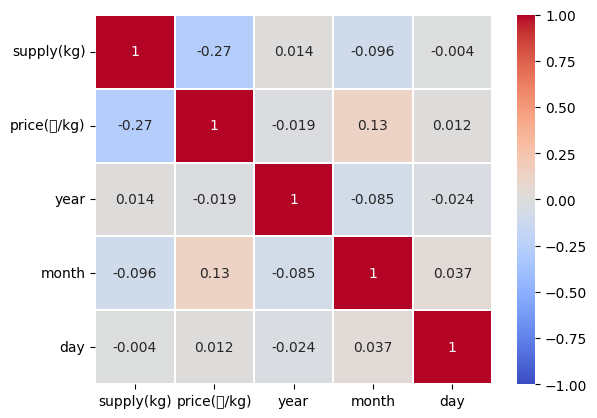

In [34]:
data = train_df.copy()
data_num = train_df.select_dtypes(include=np.number)
sns.heatmap(data_num.corr(),vmin=-1,vmax=1,annot=True,linewidths=0.2,cmap='coolwarm')

In [35]:
train_df['total'] = train_df['supply(kg)'] * train_df['price(원/kg)']

In [41]:
train_TG = train_df[train_df['item'] == 'TG']
train_TG

ID   timestamp item corporation location  supply(kg)  \
2      TG_A_J_20190103  2019-01-03   TG           A        J     60601.0   
3      TG_A_J_20190104  2019-01-04   TG           A        J     25000.0   
4      TG_A_J_20190105  2019-01-05   TG           A        J     32352.0   
6      TG_A_J_20190107  2019-01-07   TG           A        J     44995.0   
7      TG_A_J_20190108  2019-01-08   TG           A        J     26975.0   
...                ...         ...  ...         ...      ...         ...   
15225  TG_E_S_20230227  2023-02-27   TG           E        S     24204.0   
15226  TG_E_S_20230228  2023-02-28   TG           E        S     13587.0   
15227  TG_E_S_20230301  2023-03-01   TG           E        S     16187.0   
15228  TG_E_S_20230302  2023-03-02   TG           E        S     17830.0   
15229  TG_E_S_20230303  2023-03-03   TG           E        S     26157.0   

       price(원/kg)  year  month  day        total  
2           1728.0  2019      1    3  104718528.0  
3           1408.0  2019      1    4   35200000.0  
4           1250.0  2019      1    5   40440000.0  
6           1474.0  2019      1    7   66322630.0  
7           1326.0  2019      1    8   35768850.0  
...            ...   ...    ...  ...          ...  
15225       3418.0  2023      2   27   82729272.0  
15226       3141.0  2023      2   28   42676767.0  
15227       4235.0  2023      3    1   68551945.0  
15228       3960.0  2023      3    2   70606800.0  
15229       3791.0  2023      3    3   99161187.0  

[11675 rows x 11 columns]

In [42]:
train_TG.drop(columns = ['ID','timestamp','day'])

item corporation location  supply(kg)  price(원/kg)  year  month  \
2       TG           A        J     60601.0       1728.0  2019      1   
3       TG           A        J     25000.0       1408.0  2019      1   
4       TG           A        J     32352.0       1250.0  2019      1   
6       TG           A        J     44995.0       1474.0  2019      1   
7       TG           A        J     26975.0       1326.0  2019      1   
...    ...         ...      ...         ...          ...   ...    ...   
15225   TG           E        S     24204.0       3418.0  2023      2   
15226   TG           E        S     13587.0       3141.0  2023      2   
15227   TG           E        S     16187.0       4235.0  2023      3   
15228   TG           E        S     17830.0       3960.0  2023      3   
15229   TG           E        S     26157.0       3791.0  2023      3   

             total  
2      104718528.0  
3       35200000.0  
4       40440000.0  
6       66322630.0  
7       35768850.0  
...            ...  
15225   82729272.0  
15226   42676767.0  
15227   68551945.0  
15228   70606800.0  
15229   99161187.0  

[11675 rows x 8 columns]

In [43]:
grouped_data = train_TG.groupby(['year', 'month'])['total'].sum().reset_index()
grouped_data

year  month         total
0   2019      1  2.817128e+10
1   2019      2  1.407734e+10
2   2019      3  7.395534e+09
3   2019      4  1.270371e+09
4   2019      5  1.871424e+09
5   2019      6  2.600161e+09
6   2019      7  2.213851e+09
7   2019      8  2.757586e+09
8   2019      9  4.470105e+09
9   2019     10  1.106881e+10
10  2019     11  1.407608e+10
11  2019     12  1.736535e+10
12  2020      1  1.841505e+10
13  2020      2  1.394708e+10
14  2020      3  9.649112e+09
15  2020      4  2.633646e+09
16  2020      5  1.528558e+09
17  2020      6  2.360883e+09
18  2020      7  2.559993e+09
19  2020      8  3.196685e+09
20  2020      9  5.959611e+09
21  2020     10  1.152958e+10
22  2020     11  1.303707e+10
23  2020     12  1.321869e+10
24  2021      1  3.330150e+10
25  2021      2  1.562913e+10
26  2021      3  8.798646e+09
27  2021      4  3.151523e+09
28  2021      5  1.678108e+09
29  2021      6  2.164008e+09
30  2021      7  2.105502e+09
31  2021      8  2.578833e+09
32  2021      9  4.537849e+09
33  2021     10  1.075327e+10
34  2021     11  1.446541e+10
35  2021     12  1.867136e+10
36  2022      1  2.431576e+10
37  2022      2  1.054130e+10
38  2022      3  9.342552e+09
39  2022      4  5.540854e+09
40  2022      5  1.908881e+09
41  2022      6  2.333054e+09
42  2022      7  2.679255e+09
43  2022      8  3.977592e+09
44  2022      9  5.604937e+09
45  2022     10  1.177842e+10
46  2022     11  1.453050e+10
47  2022     12  2.133638e+10
48  2023      1  2.089018e+10
49  2023      2  1.510157e+10
50  2023      3  2.056648e+09

In [55]:
# year와 month를 기준으로 묶고 price의 평균값 계산
grouped_data_p = train_TG.groupby(['year', 'month'])['price(원/kg)'].mean().reset_index()
grouped_data_p

year  month  price(원/kg)
0   2019      1  1841.876000
1   2019      2  2648.383495
2   2019      3  4344.775330
3   2019      4  6130.557823
4   2019      5  7339.972727
5   2019      6  6613.459091
6   2019      7  5933.523404
7   2019      8  5475.756303
8   2019      9  4686.584475
9   2019     10  1984.936803
10  2019     11  1299.173077
11  2019     12  1269.888462
12  2020      1  1771.652174
13  2020      2  2381.372470
14  2020      3  4569.897436
15  2020      4  5866.037559
16  2020      5  7939.908654
17  2020      6  6314.312775
18  2020      7  6423.540426
19  2020      8  6289.387097
20  2020      9  5768.794979
21  2020     10  1613.067797
22  2020     11  1395.348000
23  2020     12  1347.039130
24  2021      1  1769.141026
25  2021      2  2285.627358
26  2021      3  3254.931818
27  2021      4  5829.399061
28  2021      5  7983.613734
29  2021      6  7047.421525
30  2021      7  6268.676349
31  2021      8  6476.279476
32  2021      9  5340.530303
33  2021     10  1945.207692
34  2021     11  1718.967611
35  2021     12  1785.225564
36  2022      1  2529.250000
37  2022      2  2941.421053
38  2022      3  4746.145749
39  2022      4  5745.397321
40  2022      5  7659.269231
41  2022      6  7482.533040
42  2022      7  6204.185654
43  2022      8  6170.164659
44  2022      9  5377.565611
45  2022     10  1982.215385
46  2022     11  1571.365385
47  2022     12  1947.377778
48  2023      1  2478.183857
49  2023      2  2751.397380
50  2023      3  3972.269231

In [56]:
df_sorted = grouped_data_p

# 상승률을 저장할 새로운 열을 추가합니다.
df_sorted['price_increase_rate'] = df_sorted.groupby(['year', 'month'])['price(원/kg)'].pct_change()


# 연도별로 동일한 달에 대한 상승률을 계산합니다.
yearly_avg_increase_rate = df_sorted.groupby(['year', 'month'])['price_increase_rate'].mean().reset_index()

# 결과를 출력합니다.
yearly_avg_increase_rate

year  month  price_increase_rate
0   2019      1                  NaN
1   2019      2                  NaN
2   2019      3                  NaN
3   2019      4                  NaN
4   2019      5                  NaN
5   2019      6                  NaN
6   2019      7                  NaN
7   2019      8                  NaN
8   2019      9                  NaN
9   2019     10                  NaN
10  2019     11                  NaN
11  2019     12                  NaN
12  2020      1                  NaN
13  2020      2                  NaN
14  2020      3                  NaN
15  2020      4                  NaN
16  2020      5                  NaN
17  2020      6                  NaN
18  2020      7                  NaN
19  2020      8                  NaN
20  2020      9                  NaN
21  2020     10                  NaN
22  2020     11                  NaN
23  2020     12                  NaN
24  2021      1                  NaN
25  2021      2                  NaN
26  2021      3                  NaN
27  2021      4                  NaN
28  2021      5                  NaN
29  2021      6                  NaN
30  2021      7                  NaN
31  2021      8                  NaN
32  2021      9                  NaN
33  2021     10                  NaN
34  2021     11                  NaN
35  2021     12                  NaN
36  2022      1                  NaN
37  2022      2                  NaN
38  2022      3                  NaN
39  2022      4                  NaN
40  2022      5                  NaN
41  2022      6                  NaN
42  2022      7                  NaN
43  2022      8                  NaN
44  2022      9                  NaN
45  2022     10                  NaN
46  2022     11                  NaN
47  2022     12                  NaN
48  2023      1                  NaN
49  2023      2                  NaN
50  2023      3                  NaN

# 학습에 사용할 변수 정의

In [8]:
# 학습에 사용하지 않을 변수들을 제거
train_x = train_df.drop(columns=['ID', 'timestamp', 'supply(kg)', 'price(원/kg)'])
train_y = train_df[['price(원/kg)']]

test_x = test_df.drop(columns=['ID', 'timestamp'])

test에는 supply(kg)이 없음

In [9]:
train_y

price(원/kg)
2           1728.0
3           1408.0
4           1250.0
6           1474.0
7           1326.0
...            ...
59392        468.0
59393        531.0
59394        574.0
59395        523.0
59396        529.0

[23942 rows x 1 columns]

# 수치형 스케일링

In [10]:
no_category_cols = []
category_cols = ['corporation', 'location', 'year', 'month', 'day']

train_no_category = train_x[no_category_cols]
train_category = train_x[category_cols]

train_no_category.shape, train_category.shape

((23942, 0), (23942, 5))

In [11]:
no_category_cols = []
category_cols = ['corporation', 'location', 'year', 'month', 'day']

test_no_category = test_x[no_category_cols]
test_category = test_x[category_cols]

test_no_category.shape, test_category.shape

((1092, 0), (1092, 5))

# 수치형, 범주형 합치기

In [12]:
_train_encoded = pd.DataFrame()
_test_encoded = pd.DataFrame()

for col in ['corporation', 'location', 'year', 'month', 'day']:
  _encoder = ce.OneHotEncoder(use_cat_names=True)
  _encoder.fit(train_category[col])
  _encoded = _encoder.transform(train_category[col])
  _train_encoded = pd.concat([_train_encoded, _encoded], axis=1)

  _encoded = _encoder.transform(test_category[col])
  _test_encoded = pd.concat([_test_encoded, _encoded], axis=1)

In [13]:
train_encoded = pd.concat([train_no_category, _train_encoded], axis=1)
train_encoded.shape

(23942, 11)

In [14]:
train_encoded

corporation_A  corporation_B  corporation_C  corporation_D  \
2                  1              0              0              0   
3                  1              0              0              0   
4                  1              0              0              0   
6                  1              0              0              0   
7                  1              0              0              0   
...              ...            ...            ...            ...   
59392              0              0              0              0   
59393              0              0              0              0   
59394              0              0              0              0   
59395              0              0              0              0   
59396              0              0              0              0   

       corporation_E  corporation_F  location_J  location_S  year  month  day  
2                  0              0           1           0  2019      1    3  
3                  0              0           1           0  2019      1    4  
4                  0              0           1           0  2019      1    5  
6                  0              0           1           0  2019      1    7  
7                  0              0           1           0  2019      1    8  
...              ...            ...         ...         ...   ...    ...  ...  
59392              0              1           1           0  2023      2   27  
59393              0              1           1           0  2023      2   28  
59394              0              1           1           0  2023      3    1  
59395              0              1           1           0  2023      3    2  
59396              0              1           1           0  2023      3    3  

[23942 rows x 11 columns]

In [15]:
test_encoded = pd.concat([test_no_category, _test_encoded], axis=1)
test_encoded.shape

(1092, 11)

In [16]:
train_target = train_y
train_features = train_encoded

train_features.shape, train_target.shape

((23942, 11), (23942, 1))

# K-Fold

In [17]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn import svm
from sklearn import datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import RandomizedSearchCV

In [18]:
# 교차 검증
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

## DecisionTree

In [19]:
from sklearn.tree import DecisionTreeClassifier

In [29]:
from sklearn.metrics import mean_squared_error

# ...

model = DecisionTreeClassifier(random_state=42)

n_iter = 0
rmse_lst = []

for train_index, valid_index in skf.split(train_features, train_target):
    n_iter += 1
    # 학습용, 검증용 데이터 구성
    train_x, valid_x = train_features.iloc[train_index], train_features.iloc[valid_index]
    train_y, valid_y = train_target.iloc[train_index], train_target.iloc[valid_index]

    # 학습
    model.fit(train_x, train_y)
    valid_pred = 0.4 * model.predict(valid_x)  # 예측값

    # 평가
    rmse = mean_squared_error(valid_y, valid_pred, squared=False)
    rmse_lst.append(rmse)
    print(f'{n_iter} 번째 Stratified Stratified K-Fold RMSE: {rmse}')

# 최종 평가
print('-'*50)
print(f'교차 검증 RMSE: {np.mean(rmse_lst)}')

1 번째 Stratified Stratified K-Fold RMSE: 2774.5456182343432
2 번째 Stratified Stratified K-Fold RMSE: 2787.5793519886256
3 번째 Stratified Stratified K-Fold RMSE: 2720.058536489578
4 번째 Stratified Stratified K-Fold RMSE: 2774.8565289772523
5 번째 Stratified Stratified K-Fold RMSE: 2750.9445778953145
--------------------------------------------------
교차 검증 RMSE: 2761.5969227170226


## XGBoost

### model 1

In [21]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

In [26]:
hp = {
    "random_state" : 42
}

model = XGBRegressor(**hp)
n_iter = 0
rmse_lst = []

for train_index, valid_index in skf.split(train_features, train_target):
  n_iter += 1
  # 학습용, 검증용 데이터 구성
  train_x, valid_x = train_features.iloc[train_index], train_features.iloc[valid_index]
  train_y, valid_y = train_target.iloc[train_index], train_target.iloc[valid_index]

  # 학습
  model.fit(train_x, train_y)
  valid_pred = 0.9 * model.predict(valid_x) # 예측값

  # 평가
  rmse = mean_squared_error(valid_y, valid_pred, squared=False)
  rmse_lst.append(rmse)
  print(f'{n_iter} 번째 Stratified K-Fold RMSE: {rmse}')

# 최종 평가
print('-'*50)
print(f'교차 검증 RMSE: {np.mean(rmse_lst)}')

1 번째 Stratified K-Fold RMSE: 1625.5564631187221
2 번째 Stratified K-Fold RMSE: 1666.7732610075225
3 번째 Stratified K-Fold RMSE: 1601.7182960045186
4 번째 Stratified K-Fold RMSE: 1652.653201186145
5 번째 Stratified K-Fold RMSE: 1588.4483989496869
--------------------------------------------------
교차 검증 RMSE: 1627.0299240533188


### model 2

In [ ]:
hp = {
    "random_state" : 42,
    "verbose": 0, # 로그
}
model = XGBRegressor(**hp)

In [ ]:
n_iter=3 # 몇번 hp조합을 찾을 것인가?
scoring = 'neg_root_mean_squared_error' # 어떤 평가지표를 사용할 것인가?
hp={
    "max_depth" : np.linspace(5,12,8,dtype = int), # 깊이
    "n_estimators" : np.linspace(800,1200,100, dtype = int), # 부스팅 단계수
    "learning_rate" : np.logspace(-3, -1, 3)
}

# HPO 인스턴스 생성
rs1=RandomizedSearchCV(model, hp, scoring=scoring, n_iter=n_iter, n_jobs=-1, cv=skf, verbose=False)
# 학습 (best hp 조합 찾기)
rs1.fit(train_x, train_y)

# 학습 결과 (best hp 조합일 때,)
rs1.best_score_

-1568.1648552984327

In [ ]:
best_params = rs1.best_params_
best_params

{'n_estimators': 1042, 'max_depth': 5, 'learning_rate': 0.01}

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object)

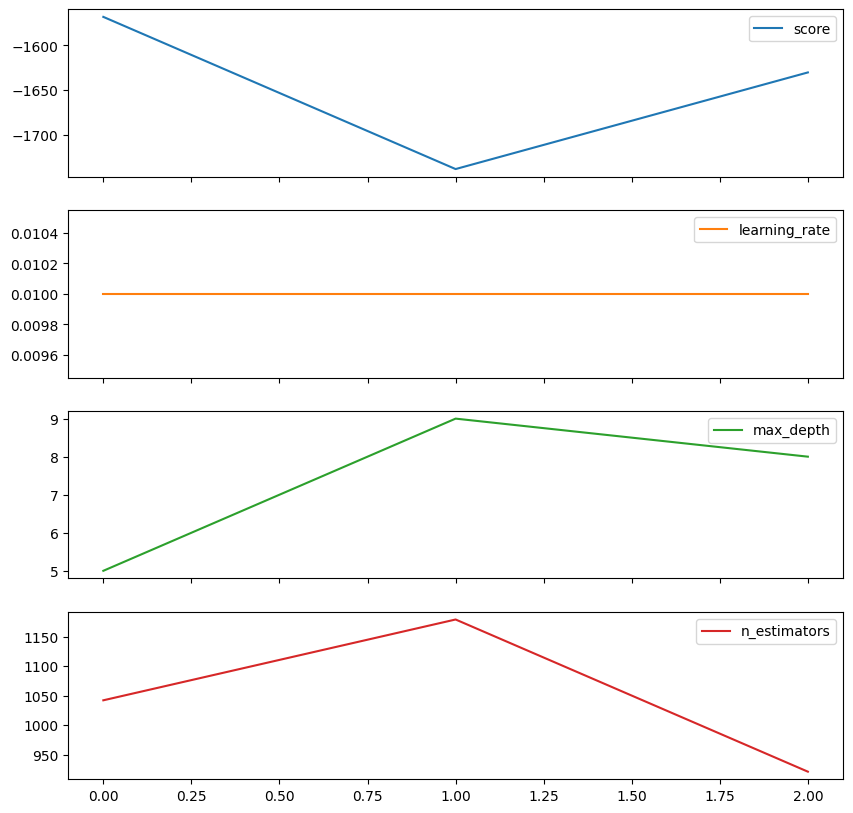

In [ ]:
rs_results_df=pd.DataFrame(np.transpose([rs1.cv_results_['mean_test_score'],
                                         rs1.cv_results_['param_learning_rate'].data,
                                         rs1.cv_results_['param_max_depth'].data,
                                         rs1.cv_results_['param_n_estimators'].data]),
                           columns=['score', 'learning_rate', 'max_depth', 'n_estimators'])
rs_results_df.plot(subplots=True,figsize=(10, 10))

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

In [ ]:
best_params['random_state'] = 42
best_params['verbose'] = 0

# best 모델 인스턴스 생성(정의)
best_mode = XGBRegressor(**hp)

In [ ]:
n_iter = 0
rmse_lst = []

for train_index, valid_index in skf.split(train_features, train_target):
  n_iter += 1
  # 학습용, 검증용 데이터 구성
  train_x, valid_x = train_features.iloc[train_index], train_features.iloc[valid_index]
  train_y, valid_y = train_target.iloc[train_index], train_target.iloc[valid_index]

  # 학습
  model.fit(train_x, train_y)
  valid_pred = model.predict(valid_x) # 예측값

  # 평가
  rmse = mean_squared_error(valid_y, valid_pred, squared=False)
  rmse_lst.append(rmse)
  print(f'{n_iter} 번째 Stratified K-Fold RMSE: {rmse}')

# 최종 평가
print('-'*50)
print(f'교차 검증 RMSE: {np.mean(rmse_lst)}')

1 번째 Stratified K-Fold RMSE: 1603.3417783520983
2 번째 Stratified K-Fold RMSE: 1652.0996569190856
3 번째 Stratified K-Fold RMSE: 1577.4587308520904
4 번째 Stratified K-Fold RMSE: 1630.441592577308
5 번째 Stratified K-Fold RMSE: 1558.2905633017106
--------------------------------------------------
교차 검증 RMSE: 1604.3264644004587


## Light GBM

### model 1

In [ ]:
from lightgbm import LGBMRegressor, plot_importance

In [ ]:
hp = {
    "random_state" : 42
}
model = LGBMRegressor(**hp)
n_iter = 0
accuracy_lst = []

for train_index, valid_index in skf.split(train_features, train_target):
  n_iter += 1
  # 학습용, 검증용 데이터 구성
  train_x, valid_x = train_features.iloc[train_index], train_features.iloc[valid_index]
  train_y, valid_y = train_target.iloc[train_index], train_target.iloc[valid_index]

  # 학습
  model.fit(train_x, train_y)
  valid_pred = model.predict(valid_x) # 예측값

  # 평가
  rmse = mean_squared_error(valid_y, valid_pred, squared=False)
  rmse_lst.append(rmse)
  print(f'{n_iter} 번째 Stratified K-Fold RMSE: {rmse}')

# 최종 평가
print('-'*50)
print(f'교차 검증 RMSE: {np.mean(rmse_lst)}')

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000392 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 67
[LightGBM] [Info] Number of data points in the train set: 19153, number of used features: 11
[LightGBM] [Info] Start training from score 2807.026001
1 번째 Stratified K-Fold RMSE: 1538.263481001628
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000383 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 67
[LightGBM] [Info] Number of data points in the train set: 19153, number of used features: 11
[LightGBM] [Info] Start training from score 2806.526079
2 번째 Stratified K-Fold RMSE: 1578.7455075108385
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing 

### model 2

In [ ]:
hp = {
    "random_state" : 42,
    "verbose": -1, # 로그
}
model = LGBMRegressor(**hp)

In [ ]:
n_iter=3 # 몇번 hp조합을 찾을 것인가?
scoring = 'neg_root_mean_squared_error' # 어떤 평가지표를 사용할 것인가?
hp={
    "max_depth" : np.linspace(5,12,8,dtype = int), # 깊이
    "n_estimators" : np.linspace(800,1200,100, dtype = int), # 부스팅 단계수
    "learning_rate" : np.logspace(-3, -1, 3)
}

# HPO 인스턴스 생성
rs1=RandomizedSearchCV(model, hp, scoring=scoring, n_iter=n_iter, n_jobs=-1, cv=skf, verbose=False)
# 학습 (best hp 조합 찾기)
rs1.fit(train_x, train_y)

# 학습 결과 (best hp 조합일 때,)
rs1.best_score_

-1561.4123991700822

In [ ]:
best_params = rs1.best_params_
best_params

{'n_estimators': 1183, 'max_depth': 7, 'learning_rate': 0.01}

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object)

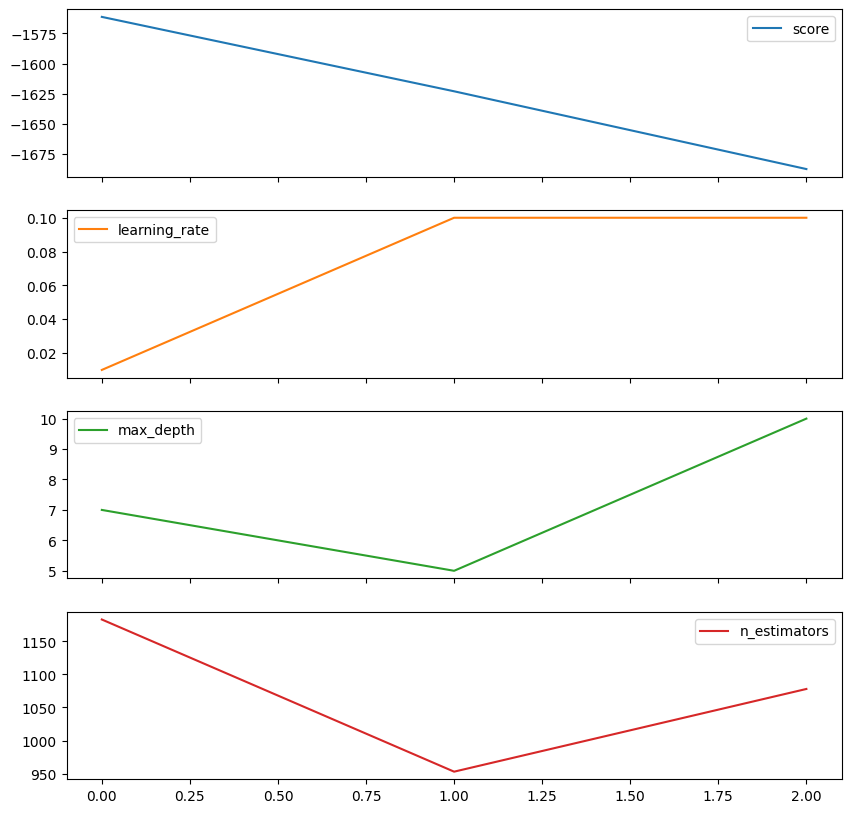

In [ ]:
rs_results_df=pd.DataFrame(np.transpose([rs1.cv_results_['mean_test_score'],
                                         rs1.cv_results_['param_learning_rate'].data,
                                         rs1.cv_results_['param_max_depth'].data,
                                         rs1.cv_results_['param_n_estimators'].data]),
                           columns=['score', 'learning_rate', 'max_depth', 'n_estimators'])
rs_results_df.plot(subplots=True,figsize=(10, 10))

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

In [ ]:
best_params['random_state'] = 42
best_params['verbose'] = -1

# best 모델 인스턴스 생성(정의)
best_mode = LGBMRegressor(**best_params)

In [ ]:
n_iter = 0
accuracy_lst = []

for train_index, valid_index in skf.split(train_features, train_target):
  n_iter += 1
  # 학습용, 검증용 데이터 구성
  train_x, valid_x = train_features.iloc[train_index], train_features.iloc[valid_index]
  train_y, valid_y = train_target.iloc[train_index], train_target.iloc[valid_index]

  # 학습
  model.fit(train_x, train_y)
  valid_pred = model.predict(valid_x) # 예측값

  # 평가
  rmse = mean_squared_error(valid_y, valid_pred, squared=False)
  rmse_lst.append(rmse)
  print(f'{n_iter} 번째 Stratified K-Fold RMSE: {rmse}')

# 최종 평가
print('-'*50)
print(f'교차 검증 RMSE: {np.mean(rmse_lst)}')

1 번째 Stratified K-Fold RMSE: 1538.263481001628
2 번째 Stratified K-Fold RMSE: 1578.7455075108385
3 번째 Stratified K-Fold RMSE: 1523.9480660011832
4 번째 Stratified K-Fold RMSE: 1565.847832383209
5 번째 Stratified K-Fold RMSE: 1499.173362526503
--------------------------------------------------
교차 검증 RMSE: 1562.2392547232675


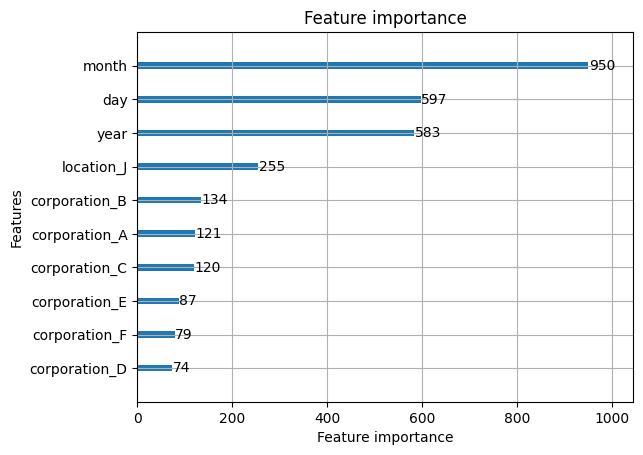

In [ ]:
plot_importance(model)
plt.show()

## catboost

### model 1

In [ ]:
from catboost import CatBoostRegressor

In [ ]:
hp = {
    "random_state" : 42,
    "verbose" : 0 # 부스팅 단계 출력 안보이게 하기
}
model = CatBoostRegressor(**hp)
n_iter = 0
accuracy_lst = []

for train_index, valid_index in skf.split(train_features, train_target):
  n_iter += 1
  # 학습용, 검증용 데이터 구성
  train_x, valid_x = train_features.iloc[train_index], train_features.iloc[valid_index]
  train_y, valid_y = train_target.iloc[train_index], train_target.iloc[valid_index]

  # 학습
  model.fit(train_x, train_y)
  valid_pred = model.predict(valid_x) # 예측값

  # 평가
  rmse = mean_squared_error(valid_y, valid_pred, squared=False)
  rmse_lst.append(rmse)
  print(f'{n_iter} 번째 Stratified K-Fold RMSE: {rmse}')

# 최종 평가
print('-'*50)
print(f'교차 검증 RMSE: {np.mean(rmse_lst)}')

1 번째 Stratified K-Fold RMSE: 1550.3275902983871
2 번째 Stratified K-Fold RMSE: 1597.863125392078
3 번째 Stratified K-Fold RMSE: 1530.716185878129
4 번째 Stratified K-Fold RMSE: 1582.4225987870218
5 번째 Stratified K-Fold RMSE: 1506.2051097243434
--------------------------------------------------
교차 검증 RMSE: 1560.0561715464487


### model 2

In [ ]:
hp = {
    "random_state" : 42,
    "verbose": 0, # 로그
}
model = CatBoostRegressor(**hp)

In [ ]:
n_iter=5 # 몇번 hp조합을 찾을 것인가?
scoring = 'neg_root_mean_squared_error' # 어떤 평가지표를 사용할 것인가?
hp={
    "max_depth" : np.linspace(5,12,8,dtype = int), # 깊이
    "n_estimators" : np.linspace(10,500,30, dtype = int), # 부스팅 단계수
    "learning_rate" : np.logspace(-3, -1, 3)
}

# HPO 인스턴스 생성
rs1=RandomizedSearchCV(model, hp, scoring=scoring, n_iter=n_iter, n_jobs=-1, cv=skf, verbose=False)
# 학습 (best hp 조합 찾기)
rs1.fit(train_x, train_y)

# 학습 결과 (best hp 조합일 때,)
rs1.best_score_

-1563.452224486768

In [ ]:
best_params = rs1.best_params_
best_params

{'n_estimators': 280, 'max_depth': 12, 'learning_rate': 0.01}

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object)

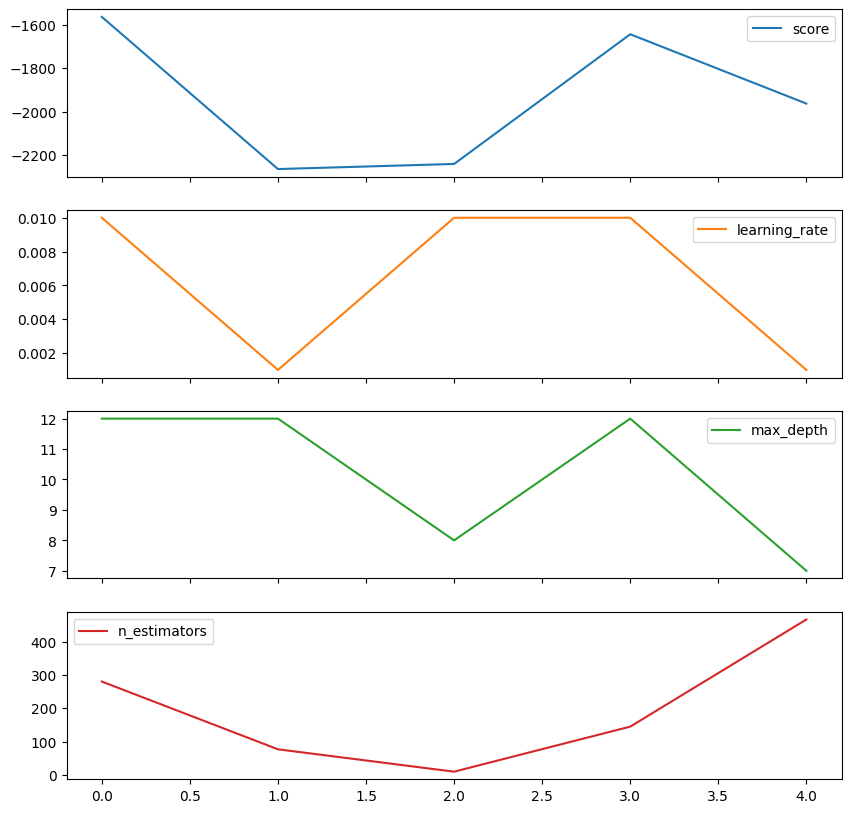

In [ ]:
rs_results_df=pd.DataFrame(np.transpose([rs1.cv_results_['mean_test_score'],
                                         rs1.cv_results_['param_learning_rate'].data,
                                         rs1.cv_results_['param_max_depth'].data,
                                         rs1.cv_results_['param_n_estimators'].data]),
                           columns=['score', 'learning_rate', 'max_depth', 'n_estimators'])
rs_results_df.plot(subplots=True,figsize=(10, 10))

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

In [ ]:
best_params['random_state'] = 42
best_params['verbose'] = 0

# best 모델 인스턴스 생성(정의)
best_mode = CatBoostRegressor(**best_params)

In [ ]:
n_iter = 0
accuracy_lst = []

for train_index, valid_index in skf.split(train_features, train_target):
  n_iter += 1
  # 학습용, 검증용 데이터 구성
  train_x, valid_x = train_features.iloc[train_index], train_features.iloc[valid_index]
  train_y, valid_y = train_target.iloc[train_index], train_target.iloc[valid_index]

  # 학습
  model.fit(train_x, train_y)
  valid_pred = model.predict(valid_x) # 예측값

  # 평가
  rmse = mean_squared_error(valid_y, valid_pred, squared=False)
  rmse_lst.append(rmse)
  print(f'{n_iter} 번째 Stratified K-Fold RMSE: {rmse}')

# 최종 평가
print('-'*50)
print(f'교차 검증 RMSE: {np.mean(rmse_lst)}')

1 번째 Stratified K-Fold RMSE: 1550.3275902983871
2 번째 Stratified K-Fold RMSE: 1597.863125392078
3 번째 Stratified K-Fold RMSE: 1530.716185878129
4 번째 Stratified K-Fold RMSE: 1582.4225987870218
5 번째 Stratified K-Fold RMSE: 1506.2051097243434
--------------------------------------------------
교차 검증 RMSE: 1558.7463216403576


Text(0.5, 1.0, 'Feature Importance')

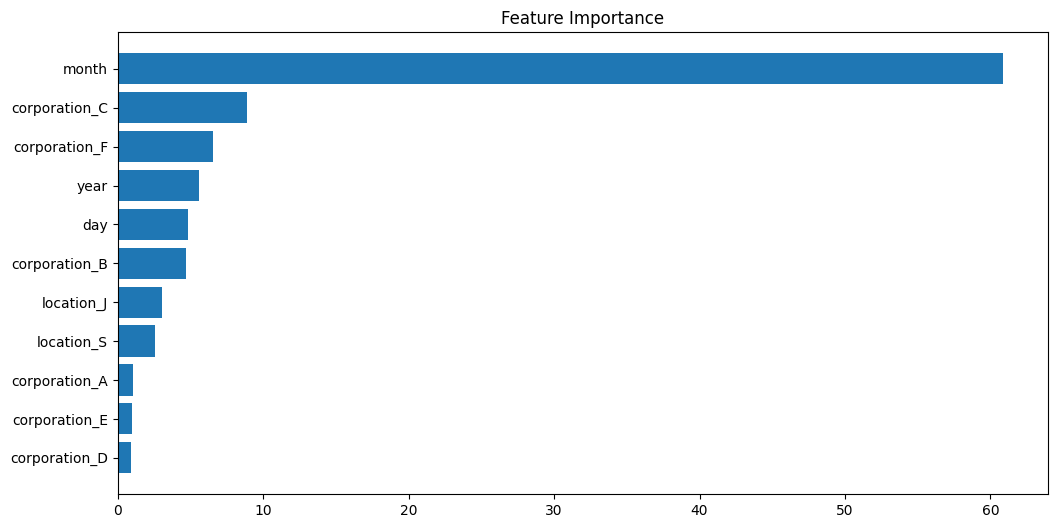

In [ ]:
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)

fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
# plt.yticks(range(len(sorted_idx)), np.array(range(len(train_x)))[sorted_idx])
# 변수명이 있다면, 아래와 같이...
plt.yticks(range(len(sorted_idx)), np.array(train_x.columns)[sorted_idx])
plt.title('Feature Importance')

## 랜덤포레스트 (수정필요)

### model 1

In [ ]:
#질적 변수들을 수치화합니다
qual_col = ['item', 'corporation', 'location']

for i in qual_col:
    le = LabelEncoder()
    train_x[i]=le.fit_transform(train_x[i])
    test_x[i]=le.transform(test_x[i]) #test 데이터에 대해서 fit하는 것은 data leakage에 해당합니다


model = RandomForestRegressor()
model.fit(train_x, train_y)

KeyError: ignored

In [ ]:
preds = model.predict(test_x)

RandomForestRegressor()

In [ ]:
preds = model.predict(test_x)

CatBoostError: ignored

# train_y, pred RMSE

In [ ]:
model

In [ ]:
pred = model.predict(train_x)

# RMSE 계산
rmse = np.sqrt(mean_squared_error(train_y, pred))
print(f'RMSE: {rmse}')

RMSE: 1464.0896067313352


In [ ]:
train_y

price(원/kg)
3           1408.0
6           1474.0
8           1428.0
9           1433.0
10          1546.0
...            ...
59389        388.0
59390        429.0
59393        531.0
59394        574.0
59395        523.0

[19154 rows x 1 columns]

In [ ]:
pred

array([1387.38021226, 1186.32771929, 1195.61683415, ...,  474.69201772,
        794.83470205,  665.4669374 ])

In [ ]:
pred_df = pd.DataFrame(pred, columns=['price(원/kg)'])
pred_df

price(원/kg)
0      1387.380212
1      1186.327719
2      1195.616834
3      1182.839972
4      1202.474473
...            ...
19149   623.350660
19150   565.089190
19151   474.692018
19152   794.834702
19153   665.466937

[19154 rows x 1 columns]

# 학습 평가

## 산포도

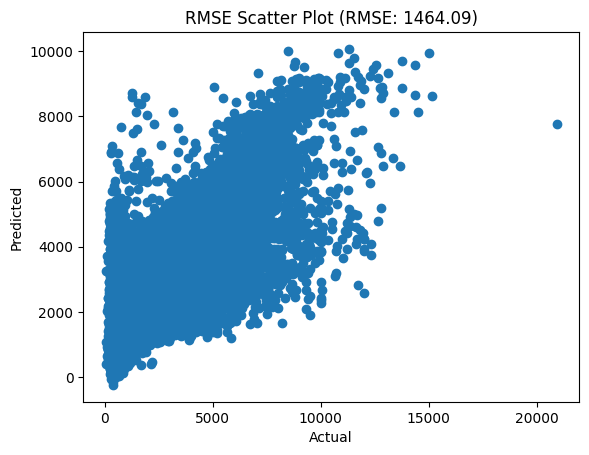

In [ ]:
import matplotlib.pyplot as plt

# train_y와 pred의 RMSE를 계산
rmse = np.sqrt(mean_squared_error(train_y, pred))

# 산포도 그래프 생성
plt.scatter(train_y, pred)

# 그래프에 제목과 x축, y축 레이블 추가
plt.title(f'RMSE Scatter Plot (RMSE: {rmse:.2f})')
plt.xlabel('Actual')
plt.ylabel('Predicted')

# 그래프 표시
plt.show()

## 예측 오차 히스토그램

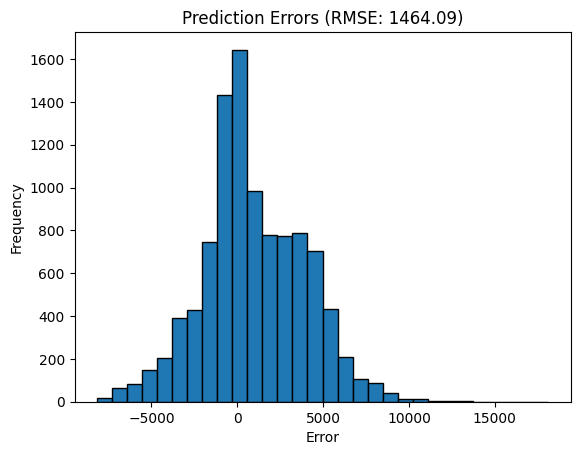

In [ ]:
# 예측 오차 계산
errors = train_y - pred_df

# RMSE 계산
rmse = np.sqrt(mean_squared_error(train_y, pred))

# 히스토그램 생성
plt.hist(errors, bins=30, edgecolor='k')

# 그래프에 제목과 x축, y축 레이블 추가
plt.title(f'Prediction Errors (RMSE: {rmse:.2f})')
plt.xlabel('Error')
plt.ylabel('Frequency')

# 그래프 표시
plt.show()

## 오차의 절대값 히스토그램

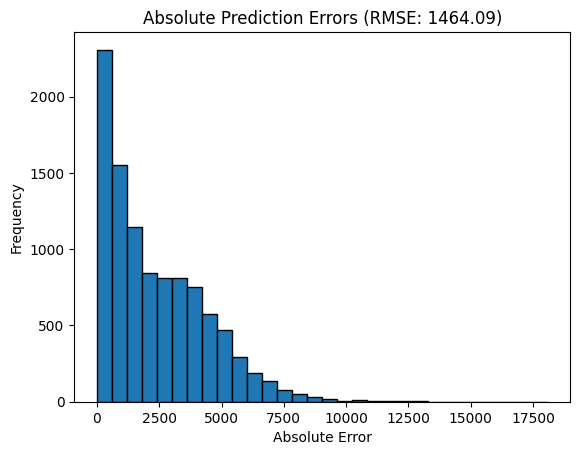

In [ ]:
# 예측 오차 계산 (절대값)
errors = np.abs(train_y - pred_df)

# RMSE 계산
rmse = np.sqrt(mean_squared_error(train_y, pred))

# 히스토그램 생성
plt.hist(errors, bins=30, edgecolor='k')

# 그래프에 제목과 x축, y축 레이블 추가
plt.title(f'Absolute Prediction Errors (RMSE: {rmse:.2f})')
plt.xlabel('Absolute Error')
plt.ylabel('Frequency')

# 그래프 표시
plt.show()

## 상위 오차 샘플 확인

In [ ]:
# 예측 오차 계산
errors = np.abs(train_y - pred_df)

# RMSE 계산
rmse = np.sqrt(mean_squared_error(train_y, pred))

# 오차와 해당 오차가 속한 샘플의 인덱스를 결합하여 튜플로 만듭니다
error_samples = list(zip(errors, range(len(errors))))

# 오차를 기준으로 정렬합니다 (내림차순)
error_samples.sort(reverse=True, key=lambda x: x[0])

# 상위 N개의 오차 샘플을 확인합니다 (여기서는 상위 10개로 예시)
top_N = 10
top_errors = error_samples[:top_N]

# 결과 출력
for error, sample_idx in top_errors:
    print(f'Sample Index: {sample_idx}, Error: {error:.2f}, True Value: {train_y.iloc[sample_idx]:.2f}, Predicted Value: {pred[sample_idx]:.2f}')


ValueError: ignored

## Residual Plot

ValueError: ignored

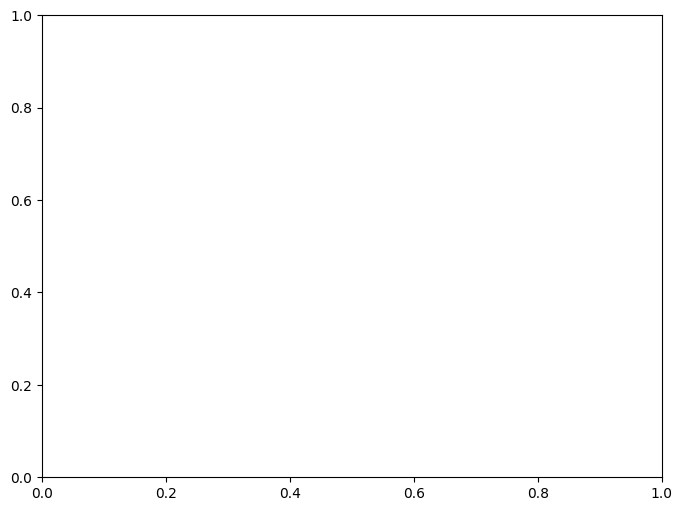

In [ ]:
# 예측값과 실제값의 차이 (잔차) 계산
residuals = train_y - pred_df

# Residual Plot 그리기
plt.figure(figsize=(8, 6))
plt.scatter(pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

# Submission

In [ ]:
submission = pd.read_csv('./sample_submission.csv')
submission

ID  answer
0     TG_A_J_20230304       0
1     TG_A_J_20230305       0
2     TG_A_J_20230306       0
3     TG_A_J_20230307       0
4     TG_A_J_20230308       0
...               ...     ...
1087  RD_F_J_20230327       0
1088  RD_F_J_20230328       0
1089  RD_F_J_20230329       0
1090  RD_F_J_20230330       0
1091  RD_F_J_20230331       0

[1092 rows x 2 columns]

In [ ]:
target_pred = model.predict(test_encoded)

In [ ]:
submission['answer'] = target_pred
submission

ID       answer
0     TG_A_J_20230304  2106.597494
1     TG_A_J_20230305  1999.621723
2     TG_A_J_20230306  1984.961693
3     TG_A_J_20230307  1950.651310
4     TG_A_J_20230308  1970.656186
...               ...          ...
1087  RD_F_J_20230327  1009.288009
1088  RD_F_J_20230328   816.623452
1089  RD_F_J_20230329   843.473068
1090  RD_F_J_20230330   790.727878
1091  RD_F_J_20230331  1038.782515

[1092 rows x 2 columns]

In [ ]:
submission.to_csv('./baseline_submission.csv', index=False)